# CellAssign
CellAssign is a probabilistic model that uses prior knowledge of cell-type marker genes to annotate scRNA data into predefined cell types.

only needs to know whether or not each given gene is a marker of each cell type

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
from scvi.external import CellAssign
import seaborn as sns
import tempfile

/tmp/ipykernel_3201604/2246931223.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

### Load Data

In [3]:
hgsc_adata = sc.read_h5ad('sce_hgsc_annotated_final.h5ad')
hgsc_celltype_markers = pd.read_csv('HGSC_celltype.csv',index_col=0)

hgsc_adata.var_names_make_unique()
hgsc_adata.obs_names_make_unique()

hgsc_adata

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4848 × 33694
    obs: 'Sample', 'dataset', 'patient', 'timepoint', 'site', 'sample_barcode', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_feature_control', 'pct_counts_in_top_100_fe

In [4]:
hgsc_celltype_markers.head(n=10)

,B cells,T cells,Monocyte/Macrophage,Epithelial cells,Ovarian stromal cells,Ovarian myofibroblast,Vascular smooth muscle cells,Endothelial cells,other
Gene,,,,,,,,,
ACTA2,0,0,0,0,0,1,1,0,0
ARX,0,0,0,0,1,1,0,0,0
BANK1,1,0,0,0,0,0,0,0,0
CD14,0,0,1,0,0,0,0,0,0
CD19,1,0,0,0,0,0,0,0,0
CD2,0,1,0,0,0,0,0,0,0
CD28,0,1,0,0,0,0,0,0,0
CD33,0,0,1,0,0,0,0,0,0
CD3D,0,1,0,0,0,0,0,0,0


### Create and Fit CellAssign Model

In [5]:
hgsc_bdata = hgsc_adata[:, hgsc_celltype_markers.index].copy()
scvi.external.CellAssign.setup_anndata(hgsc_bdata, "size_factor")
hgsc_model = CellAssign(hgsc_bdata, hgsc_celltype_markers)
hgsc_model.train()

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount(

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 53/400:  13%|█▎        | 52/400 [00:22<02:23,  2.43it/s, loss=64.6, v_num=1]

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<Axes: xlabel='epoch'>

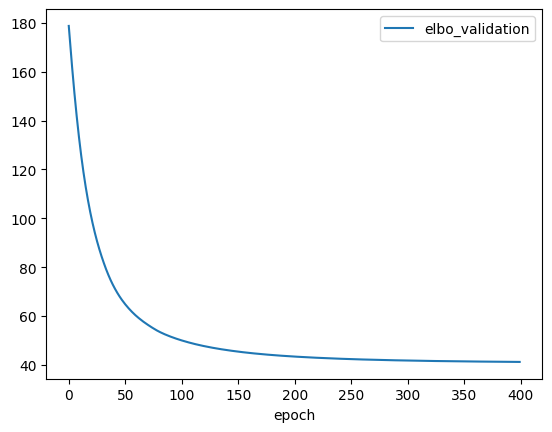

In [10]:
#Inspecting the convergence:
hgsc_model.history["elbo_validation"].plot()

### Predict and Plot Assigned Cell Types

Predict the soft cell type assignment probability for each cell.

In [12]:
predictions_hgsc = hgsc_model.predict()
predictions_hgsc.head()

,B cells,T cells,Monocyte/Macrophage,Epithelial cells,Ovarian stromal cells,Ovarian myofibroblast,Vascular smooth muscle cells,Endothelial cells,other
0,1.426365e-60,1.564347e-63,4.239438e-64,1.899544e-69,4.962986e-50,9.999999e-01,1.130211e-07,1.072492e-60,3.136060e-68
1,7.871124e-10,4.757956e-12,4.391094e-12,2.181130e-18,9.999985e-01,1.469199e-06,1.766104e-12,1.775651e-11,2.651815e-18
2,2.480904e-13,2.091629e-16,2.676803e-17,1.000000e+00,1.241497e-14,5.281570e-18,9.303781e-19,1.310923e-15,1.230973e-10
3,3.726875e-24,3.302690e-27,4.817369e-28,1.000000e+00,4.769374e-25,2.806153e-28,4.478506e-30,4.345278e-27,3.898305e-22
4,1.230335e-20,1.000000e+00,2.024603e-24,2.416058e-37,9.478557e-17,9.718798e-27,4.843208e-33,1.569007e-31,9.502740e-37


We can visualize the probabilities of assignment with a heatmap that returns the probability matrix for each cell and cell type.

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


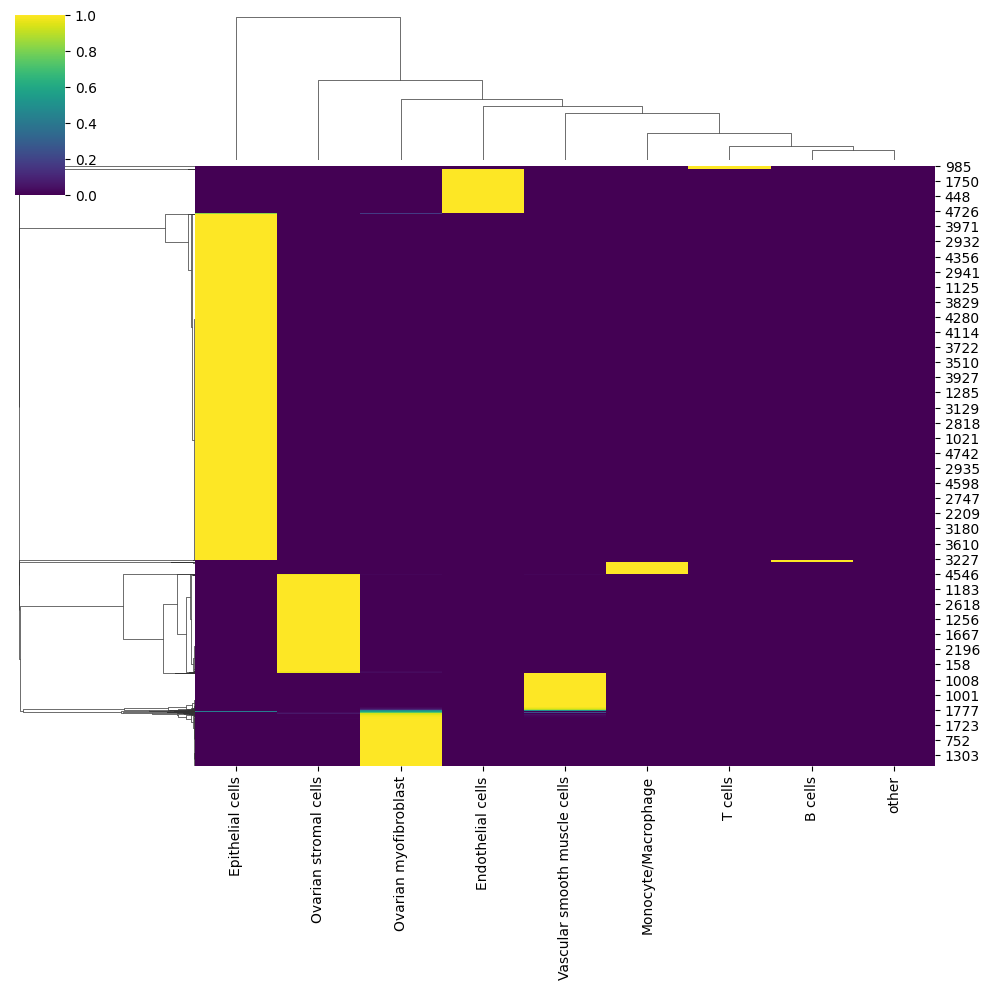

In [13]:
sns.clustermap(predictions_hgsc, cmap="viridis")

In [14]:
hgsc_bdata.obs["cellassign_predictions"] = predictions_hgsc.idxmax(axis=1).values

We then create a UMAP plot labeled by maximum probability assignments from the CellAssign model. 

The left plot contains the true cell types and the right plot contains our model’s predictions.

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

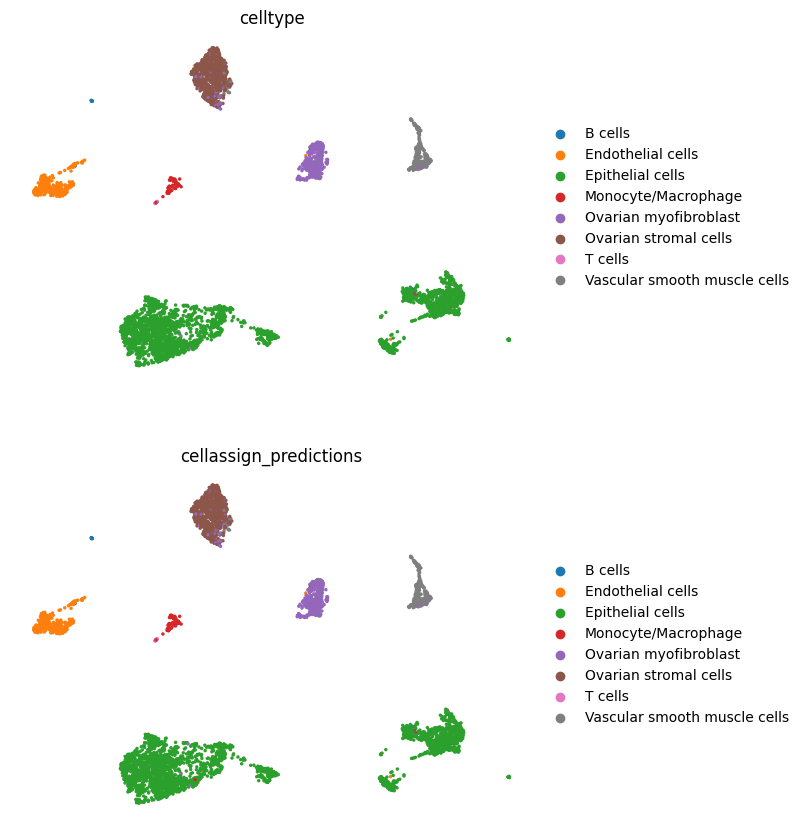

In [15]:
sc.pl.umap(
    hgsc_bdata,
    color=["celltype", "cellassign_predictions"],
    ncols=1,
    frameon=False,
)

### Model Reproducibility
We see that the scvi-tools implementation highly reproduces the original implementation’s predictions.

/tmp/ipykernel_1253389/2305008793.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


<Axes: xlabel='Original predictions', ylabel='cellassign_predictions'>

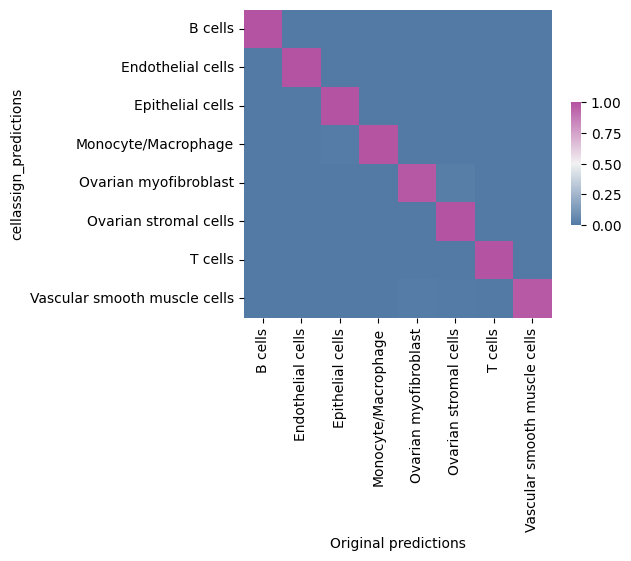

In [16]:
df = hgsc_bdata.obs
confusion_matrix = pd.crosstab(
    df["cellassign_predictions"],
    df["celltype"],
    rownames=["cellassign_predictions"],
    colnames=["Original predictions"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws={"shrink": 0.4, "aspect": 12},
)